# Sources

The exercise is taken from "Using data mining to predict secondary school student performance" by P. Cortez and A. Silva (2008).

- https://lifewithdata.com/2022/03/13/how-to-remove-highly-correlated-features-from-a-dataset/
- https://app.pluralsight.com/player?course=building-regression-models-scikit-learn&author=janani-ravi&name=1616b48f-65fd-4abd-b9fa-7a2560c9d5de&clip=3
- https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1
- https://scikit-learn.org/stable/modules/tree.html
- https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

# Notation

|General Notation | Description | Python (if applicable) |
|---|---|---|
| $a$ | scalar ||
| $\vec{a}$ | vector ||
| $A$ | matrix ||
| **Multiple variable regression** | | |
| $x$ | "input" variable, feature ||
| $y$ | "output" variable, target ||
|  $X$ | training example matrix | `X_train` |   
|  $\vec{y}$  | training example  targets | `y_train` |
|  $\vec{x}^{(i)}$| features of $ith$ Training example | |
|  $\vec{x}^{(i)}$, $y^{(i)}$ | $i{th}$ Training example | |
| $x_n^{(i)}$ | value of feature n in ith training example ||
| m | number of training examples | `m` |
| n | number of features in each example | `n` |
|  $\vec{w}$  |  parameter: weights | `w` |
| $b$ | parameter: y-intercept | `b` |     
| $f_{\vec{w},b}(\vec{x}^{(i)})$ | the result of the model evaluation at $\vec{x}^{(i)}$ parameterized by $\vec{w},b$: $f_{\vec{w},b}(\vec{x}^{(i)}) = \vec{w} \cdot \vec{x}^{(i)}+b$  | `f_wb` | 
| **Gradient descent** | | |
| $\alpha$ | learning rate ||
| $\frac{\partial J(\vec{w},b)}{\partial w_n}$ | partial derivative term ||

# Initial dependencies and data import

You are asked to predict a final grade of the math course based on the information we have about the student. The dataset is provided in the accompanying file 'student-mat.csv'. A full description of the data set can be found in the file 'metadata.txt'.

In [654]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

# Read from csv.
mathscores = pd.read_csv('./data/student-mat.csv', sep=';')

# Data exploration

In [655]:
mathscores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## G3 distribution

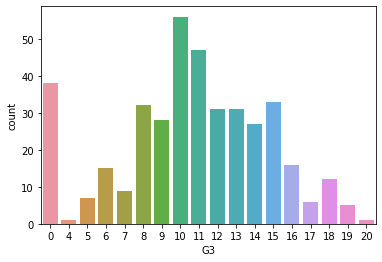

In [656]:
ax = sns.countplot(x="G3", data=mathscores)

# Model 1: Multiple variable linear regression

## Data preparation

Seaborn is a library that allows a.o. to generate heatmaps. Before calling the library's methods, the correlation matrix of the dataset is computed. In order to perform dimensionality reduction, we want to exclude the variables from the dataset which represent the same information as the one we try to predict. 

The heatmap hereunder shows a very high correlation between G1, G2 and G3 (respectively 0.8 and 0.9). For the purpose at hand, this means that adding G1 and G2 to the dataset would likely increase the predictive power of our model. However, if we are interested in understanding the socio-economic features having a high impact on students' results, we are better off discarding them.

Another approach would be to do feature engineering and compute an average of G1, G2 and G3 and set that as the target.

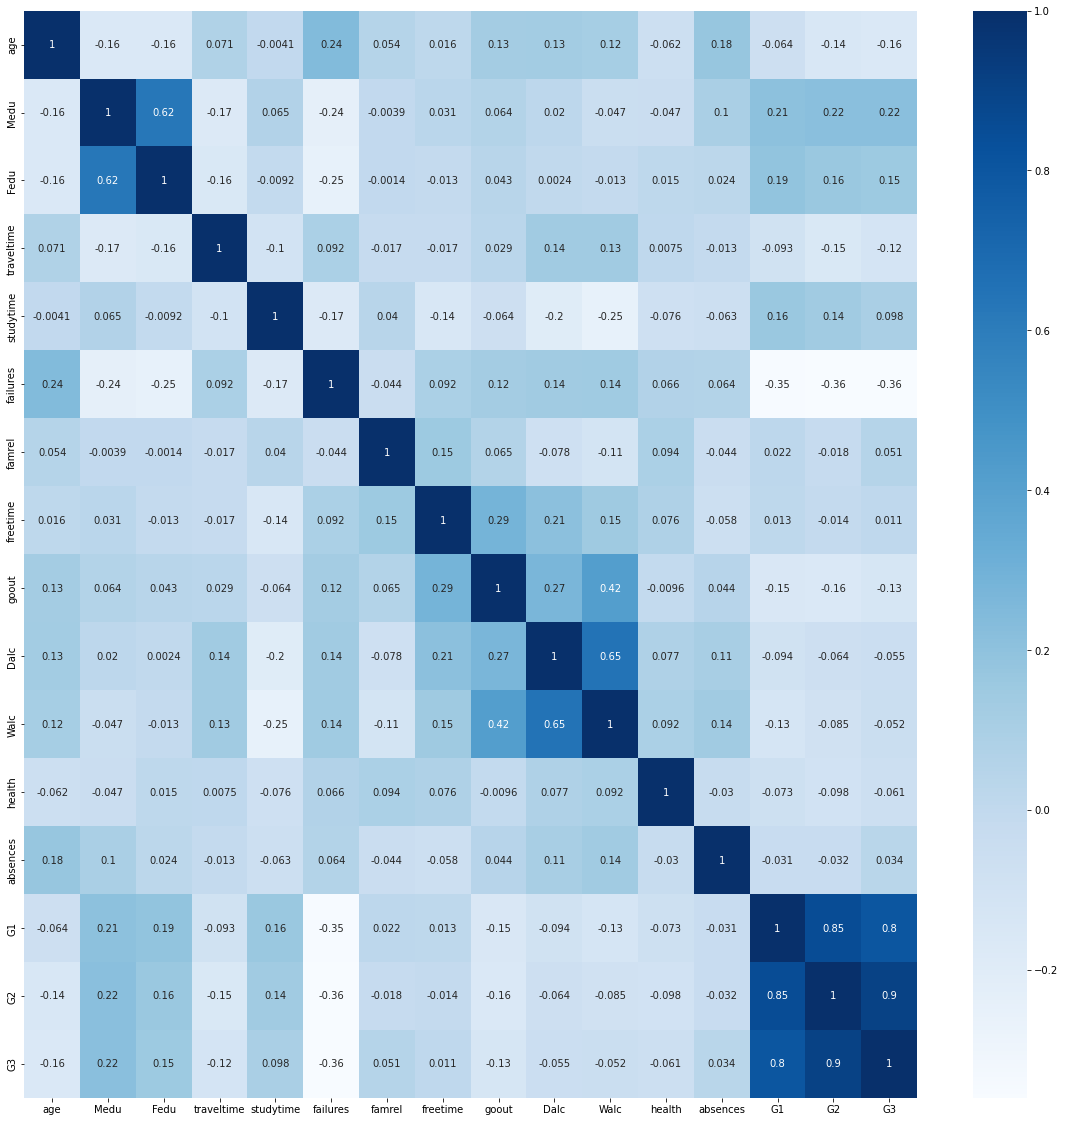

In [657]:
import seaborn as sns

corr_matrix = mathscores.corr()

plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix, annot = True, cmap="Blues")

# Alternative to heatmap
# print(mathscores.corr()['G3'].sort_values())
mathscores_without_G1_G2_G3 = mathscores.drop(['G1', 'G2', 'G3'], axis = 'columns')

The next step is to pre-process the dataset before feeding it to the machine learning model. Pre-processing means performing scaling of numeric features and/or encoding of categorical features in order to regularize the data. This increases the efficiency of the machine learning step.

We will encode categorical data using one-hot encoding.

In order to tackle the issue of overfitting, the dataset is split into two subsets: `X_train` and `X_test`. The model is trained on the former and the latter is used to perform the actual prediction. The accuracy of the prediction can be measured thanks to standard metrics. Baseline models can also be used for comparison.

In [658]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

mathscores_without_G1_G2_G3.info()

# One-hot encoding of categorical features
# categorical_features = mathscores_without_G1_G2_G3.select_dtypes(exclude = ['int64'])
# categorical_features_cols = categorical_features.columns.to_series()
# X = pd.get_dummies(mathscores_without_G1_G2_G3, columns = categorical_features_cols)

mathscores_ohe = pd.get_dummies(mathscores_without_G1_G2_G3, columns = ['Mjob', 'Fjob', 'reason', 'guardian'])

binary_features = mathscores_ohe.select_dtypes(exclude = ['int64', 'uint8'])
binary_features_cols = binary_features.columns.values.tolist()
nominal_features = mathscores_ohe.select_dtypes(include = ['uint8'])
nominal_features_cols = nominal_features.columns.values.tolist()
numeric_features = mathscores_without_G1_G2_G3.select_dtypes(include = ['int64'])
numeric_features_cols = numeric_features.columns.values.tolist()

# Ordinal encoding of binary features. Ordinal encoding is not really meant for this purpose.
ord_enc = OrdinalEncoder(dtype = 'int64')
binary_features = ord_enc.fit_transform(binary_features)

concatenated_cols = binary_features_cols + nominal_features_cols + numeric_features_cols
concatenated = np.concatenate((binary_features, nominal_features, numeric_features), axis = 1)

# Scale all features.
# sc = StandardScaler()
# concatenated_scaled = sc.fit_transform(concatenated)

X = pd.DataFrame(concatenated, columns = concatenated_cols)

print(X.info())

X.to_csv(r'./data/concatenated.csv', index = None, header=True)

y = mathscores['G3']

# 80% - 20% split for the training and testing sets. 316/395 = 0.8 
# Assign train and test sets (in your experiments, you want to do cross-validation).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X shape: {X_train.shape}, X type:{type(X_train)})")
print(f"y shape: {y_train.shape}, y type:{type(y_train)})")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [659]:
# Describe target
print(mathscores['G3'].describe())

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64


## Create and fit the regression model

In mathematical terms, the model function can be expressed as:

$f_{\vec{w},b}(\vec{x}^{(i)}) = \vec{w} . \vec{x} + b$

The values of the $\vec{w}$ vector are called the weights. $b$ is a scalar value and is called the y-intercept. The goal is to find values for these parameters so that $J(\vec{w}, b)$ - the cost function applied to arguments $\vec{w}$, $b$ - is close to zero, meaning that the values cause the algorithm to fit the training set very well. Gradient descent is an algorithm that aims to achieve this task as efficiently as possible by repeatedly taking steps in the direction of steepest decrease of $J$.

The algorithm can be formalized as follows:



$$\text{repeat} \text{ until convergence:} \; \lbrace \newline
\;  w_n = w_n -  \alpha \frac{\partial J(\vec{w},b)}{\partial w_n}  \; \newline

b = b -  \alpha \frac{\partial J(\vec{w},b)}{\partial b}  \newline \rbrace
$$

where

$$\frac{\partial J(\vec{w},b)}{\partial w_n}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})x_n^{(i)} \newline
  \frac{\partial J(\vec{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\vec{w},b}(\vec{x}^{(i)}) - y^{(i)})$$

In [660]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

### Parameters

In [661]:
w = linear_model.coef_
df_w = pd.DataFrame(w, X.columns, columns=['coef']).sort_values(by='coef', ascending=False)

print(df_w)

b = linear_model.intercept_

print(f"b = {b:0.2f}")

                           coef
reason_other       2.093907e+12
reason_reputation  2.093907e+12
reason_course      2.093907e+12
reason_home        2.093907e+12
guardian_other     1.743317e+12
guardian_mother    1.743317e+12
guardian_father    1.743317e+12
Fjob_teacher       5.990615e+11
Fjob_health        5.990615e+11
Fjob_at_home       5.990615e+11
Fjob_services      5.990615e+11
Fjob_other         5.990615e+11
higher             1.751593e+00
sex                1.495914e+00
paid               7.692098e-01
studytime          7.574069e-01
school             7.286388e-01
internet           7.215378e-01
famsize            6.968263e-01
Medu               4.673742e-01
address            3.430369e-01
famrel             2.930395e-01
freetime           2.491848e-01
absences           6.633125e-02
Walc               4.193294e-02
Dalc              -1.450627e-01
health            -1.465384e-01
Fedu              -1.497426e-01
traveltime        -2.630473e-01
nursery           -3.083830e-01
age     

### Make predictions

In [662]:
print(f"Prediction on training set:\n{linear_model.predict(X_train)[:10]}")
# @ sign computes the dot product of vectors X[i] and w.
print(f"prediction using w,b:\n{(X_train @ w + b)[:10]}")
print(f"Target values:\n{y_train[:10]}")

y_pred = linear_model.predict(X_test)

df_pred_actual = pd.DataFrame({'predicted': y_pred, 'actual': y_test})

df_pred_actual.head(10)


Prediction on training set:
[12.08935547 10.67285156  2.21728516  9.03515625 10.12548828  8.27685547
  8.60205078  8.15478516 13.77099609 11.71044922]
prediction using w,b:
181    12.089355
194    10.672852
173     2.217285
63      9.035156
253    10.125488
225     8.276855
331     8.602051
383     8.154785
227    13.770996
342    11.710449
dtype: float64
Target values:
181    12
194    14
173     0
63      9
253     8
225     7
331    14
383     0
227    12
342    15
Name: G3, dtype: int64


,predicted,actual
78,1.886230,10
371,7.458008,12
248,8.312500,5
55,11.550781,10
390,10.206055,9
223,9.433105,13
42,13.209961,18
234,12.691895,6
316,10.265625,0
116,12.341309,14


### Metrics

A regressor should present a RMSE close to zero. The mean squared error (MSE) of an estimator measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value. Taking the square root of MSE yields the root-mean-square error (RMSE), which has the same units as the quantity being estimated.

The coefficient of determination (r2) is easier to interpret as it can be expressed as a percentage.

In [663]:
from sklearn.metrics import mean_squared_error, r2_score

print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
# 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Root mean squared error: 4.20
Coefficient of determination: 0.14


### Plot predicted vs actuals

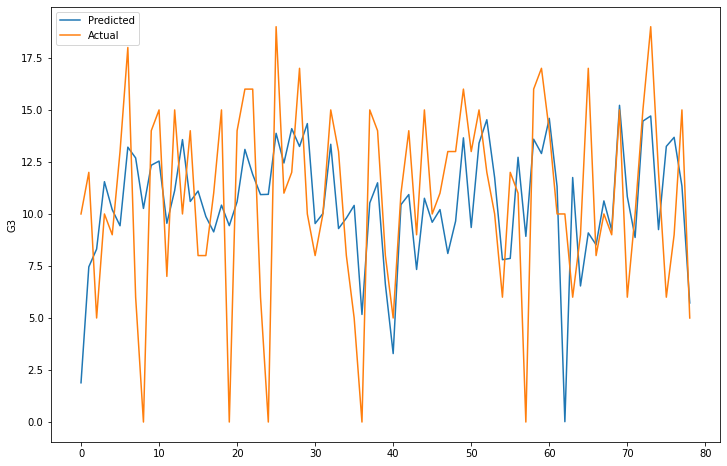

In [664]:
plt.figure(figsize = (12, 8))

plt.plot(y_pred, label='Predicted')
plt.plot(y_test.values, label='Actual')

plt.ylabel('G3')

plt.legend()
plt.show()

### Improving the model

We try to improve the model by selecting the variables which correlate the most with the target. Reducing the number of features can reduce the noise, thereby increasing accuracy and performance of the training step. We obtain a model which is slightly more accurate.

In [665]:
concat = pd.concat([X, mathscores['G3']], axis = 1)
print(concat.info())

most_corr = concat.corr().abs()['G3'].sort_values(ascending = False)
most_corr.drop('G3', inplace = True)
print(most_corr.head(7))

X_temp = pd.DataFrame(concatenated, columns = concatenated_cols)
X = X_temp[['failures', 'Medu', 'higher', 'age', 'Fedu', 'goout', 'romantic']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

print("Root mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
# 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school             395 non-null    int64
 1   sex                395 non-null    int64
 2   address            395 non-null    int64
 3   famsize            395 non-null    int64
 4   Pstatus            395 non-null    int64
 5   schoolsup          395 non-null    int64
 6   famsup             395 non-null    int64
 7   paid               395 non-null    int64
 8   activities         395 non-null    int64
 9   nursery            395 non-null    int64
 10  higher             395 non-null    int64
 11  internet           395 non-null    int64
 12  romantic           395 non-null    int64
 13  Mjob_at_home       395 non-null    int64
 14  Mjob_health        395 non-null    int64
 15  Mjob_other         395 non-null    int64
 16  Mjob_services      395 non-null    int64
 17  Mjob_teacher    

# Median baseline

This metric is used as baseline for model 1. For regression models, it is common to create a baseline model that predicts the median of the training dataset. 

In [666]:
median_pred = y_train.median()

# prediction has constant value
prediction = [median_pred for _ in range(len(X_test))]

def evaluate_predictions(y_test, prediction):
    rmse = mean_squared_error(y_test, prediction, squared = False)
    
    return rmse

baseline_rmse = evaluate_predictions(y_test, prediction)
print('Median baseline RMSE: {:.4f}'.format(baseline_rmse))

Median baseline RMSE: 4.5340


# Model 2: Decision trees

As second model, we choose to use a different type of algorithm. Decision tree enables us to discover another kind of machine learning logic.

## Data preparation

The targer variable $y$ will be a category. One of the strategies used by the original authors of the study was to split up the target in five categories before feeding it to tree-based ML-models. We will use the same approach here.

The categories are:

- A: 16-20
- B: 14-15
- C: 12-13
- D: 10-11
- E: 0-9 

In [667]:
mathscores_without_G1_G2_G3 = mathscores.drop(['G1', 'G2', 'G3'], axis = 'columns')

# Organize targets in a classification system.
def define_label(df):
    classification_list = []
    for score in df:
        if score > 15:
            classification_list.append('A')
        elif score > 13 and score < 16:
            classification_list.append('B')
        elif score > 11 and score < 14:
            classification_list.append('C')
        elif score > 9 and score < 12:
            classification_list.append('D')
        elif score < 10:
            classification_list.append('E')

    return classification_list

y = pd.Series(define_label(mathscores['G3']))

# In order to feed data to DT model, we need to submit categorical features to one-hot encoding.
# From the scikit documentation, we understand that continous features (age, absences) are partitioned into a discrete set of intervals.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X shape: {X_train.shape}, X type:{type(X_train)})")
print(f"y shape: {y_train.shape}, y type:{type(y_train)})")

X shape: (316, 7), X type:<class 'pandas.core.frame.DataFrame'>)
y shape: (316,), y type:<class 'pandas.core.series.Series'>)


## Create and fit the classification model

The decision tree algorithm functions as follows:

- Of all features, the one with the highest information gain is selected. This feature will serve as the top node. Information gain means the reduction in entropy that you get in the tree from making a given split. Less entropy means greater purity of the node.
- The dataset is split is left and right branches according to the selected feature.
- This process is repeated until the stopping criteria is met.

The stopping criterium can be:
- Stop when a node is 100% one class.
- Stop when splitting a node will result in the tree exceeding a preconfigured max depth.
- Stop when the information gain from additional splits is less than a set threshold.
- Stop when number of examples in a node is below a threshold.

Entropy can be formalized as: 

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

And the information gain as:

$$\text{Information Gain} = H(p_1^\text{node})- (w^{\text{left}}H(p_1^\text{left}) + w^{\text{right}}H(p_1^\text{right}))$$

where 
- $H(p_1^\text{node})$ is entropy at the node.
- $H(p_1^\text{left})$ and $H(p_1^\text{right})$ are the entropies at the left and the right branches resulting from the split.
- $w^{\text{left}}$ and $w^{\text{right}}$ are the proportion of examples at the left and right branch, respectively.

In the scikit-learn implementation, the nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [668]:
from sklearn import tree

dt_model = tree.DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

### Make predictions

In [669]:
y_pred = dt_model.predict(X_test)

### Metrics

In [670]:
from sklearn.metrics import accuracy_score

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.3165


### Improving the model

By tuning the hyperparameters, it is possible to increase the accuracy of the DT model. 

`max_depth` set the maximum depth of the tree. 

In [671]:
dt_model = tree.DecisionTreeClassifier(max_depth = len(X.columns))
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.2785
